# Deep Python 2024

Автор: Жемуков Альберт Артурович

студент БПМИ 239

## Предисловие

После самостоятельного изучения библиотеки, ее документации и гайдов по ней, я создал этот доклад. Вместо исключительного объяснения как работает каждый метод, я постарался показать это преимущественно на примерах (котрые постарался сделать достаточно интересными). То есть, доклад это своего рода выжимка != документация. Он создан именно с целью потыкать код и при этом понять, что происходит. Другими словами, фундаментальные объяснения, которые есть в документации здесь вряд ли будут. Доклад построен на практических примерах.

With that out of the way, погнали дальше!

![chillguy](images/justachillguy-v0-cnvsm1t7p82e1.png.webp)

## Dask

![logo](images/images.png)

Dask - это библиотека для параллельных вычислений и масштабирования. Допустим, что Numpy не справляется с объемом данных, который нам нужно будет обработать. В таком случае естественной альтернативой как раз станет Dask. Dask предоставляет возможность работать с данными, которые превышают объем оперативной памяти, и эффективно использовать ресурсы как на локальной машине, так и на кластере. Библиотека позволяет масштабировать код Python с минимальными изменениями.

## Немного теории

Кластер — это группа компьютеров, объединённых вместе для совместного выполнения задач. Они работают как единая система и часто используются для увеличения производительности, масштабируемости и надежности.

Кластер работает благодаря взаимодействию нескольких компонентов. Контроллер (мастер-узел) отвечает за управление распределением задач между узлами, отслеживает их состояние и следит за использованием ресурсов, таких как память и процессоры. Рабочие узлы (worker-узлы) выполняют задачи, которые им передает контроллер, обрабатывают данные или производят вычисления. Все узлы в кластере связаны между собой через локальную или облачную сеть, что позволяет им обмениваться данными и координировать выполнение задач в реальном времени.

Dask поддерживает работу на локальном компьютере, но его ключевая сила — распределенные вычисления на кластерах.

Кластеры — это основа современных вычислений, особенно в сфере анализа данных, машинного обучения и высокопроизводительных вычислений.

## Полезные ссылки

[Официальная документация либы](https://docs.dask.org/en/stable/)

[Официальный туториал](https://tutorial.dask.org/00_overview.html)

[Офигенная статья на Хабре](https://habr.com/ru/companies/otus/articles/759552/)

## Установка

Здесь все стандартно:

In [ ]:
%pip install "dask[complete]"

## Dask Array

Dask Array — это масштабируемая версия массива NumPy, которая работает с массивами, превышающими объем оперативной памяти, и распределяет вычисления между несколькими ядрами или машинами.

- Dask Array поддерживает API NumPy, что позволяет использовать знакомые функции и методы.

- Массивы разбиваются на более мелкие блоки, которые обрабатываются независимо.

- Поддерживаются вычисления как на локальной машине, так и в распределенных системах.

Рассмотрим для начала пример:

In [ ]:
import numpy as np
import dask.array as da

# Создаем обычный NumPy массив размером 10x10
x = np.arange(100).reshape(10, 10)
# Преобразуем NumPy массив в Dask Array с чанками (разбиением) 5x5
dask_array = da.from_array(x, chunks=(5, 5))

result = dask_array.mean()
print(result.compute())

Разберемся, что здесь вообще происходит.

Вместо того чтобы обрабатывать весь массив сразу, Dask делит его на чанки, что позволяет работать с большими данными, превышающими оперативную память.
Выполнение вычислений параллелизуется, что ускоряет процесс на многопроцессорных системах.

![dask-array](images/dask-array-2.png)

На изображении показано, как Dask Array разбивает большой массив на более мелкие части — чанки. Каждый чанк представляет собой отдельный NumPy массив.

Пусть нам нужно вычислить индекс растительности NDVI для спутниковых данных, представляющих 10 сцен, каждая из которых состоит из двух каналов: ближний инфракрасный (NIR) и красный (Red). NDVI является важным показателем для анализа растительности, так как он показывает степень активности фотосинтеза в растительных покровах.

In [ ]:
# Генерируем массив данных: снимки 10000x10000 (10 сцен, 2 канала: NIR и Red)
satellite_data = da.random.random((10, 2, 10_000, 10_000), chunks=(1, 2, 5000, 5000))

# Разделяем каналы
nir = satellite_data[:, 0, :, :]  # Near Infrared
red = satellite_data[:, 1, :, :]  # Red

# Вычисляем NDVI
ndvi = (nir - red) / (nir + red)

print("NDVI сцены 1, пиксель [0, 0]:", ndvi[0, 0, 0].compute())

Попробуем сделать то же самое с NumPy (этот код ниже лучше не запускать)

In [ ]:
# Генерируем аналогичный массив данных: снимки 10000x10000 (10 сцен, 2 канала)

# numpy_satellite_data = np.random.random((10, 2, 10_000, 10_000))

# Разделяем каналы
# nir = numpy_satellite_data[:, 0, :, :]  # Near Infrared
# red = numpy_satellite_data[:, 1, :, :]  # Red

# Вычисляем NDVI
# try:
    # ndvi = (nir - red) / (nir + red)
    # print("NDVI сцены 1, пиксель [0, 0]:", ndvi[0, 0, 0])
# except MemoryError:
    # print("NumPy не справился: данные слишком велики для оперативной памяти.")

Таким образом, мы посмотрели как работают массивы в Dask. Теперь потыкаем Bag

## Dask Bag

Dask Bag — это компонент библиотеки Dask, предназначенный для параллельной обработки коллекций произвольных Python объектов с использованием операций, таких как map, filter, fold и groupby. Он эффективно работает с неструктурированными или полуструктурированными данными, такими как текстовые файлы, лог-файлы, JSON-записи или пользовательские объекты Python.

Рассмотрим задачу подсчета наиболее частых слов в наборе текстовых файлов (например, анализ лог-файлов).

In [ ]:
import random
import string
from datetime import datetime
from dask.distributed import Client
import dask.bag as db

# Запуск Dask Dashboard
client = Client()
print(client.dashboard_link)

# Функция для генерации случайной строки логов
def generate_log_line():
    ip = ".".join(str(random.randint(0, 255)) for _ in range(4))  # Генерация случайного IP-адреса
    timestamp = datetime.now().strftime('%d/%b/%Y:%H:%M:%S')  # Текущее время в формате логов
    http_methods = ["GET", "POST", "PUT", "DELETE", "PATCH"]
    method = random.choice(http_methods)  # Случайный HTTP-метод
    url = "/" + "/".join(
        ''.join(random.choices(string.ascii_lowercase, k=random.randint(3, 10))) for _ in range(3)
    )  # Случайный URL
    status = random.choice([200, 201, 400, 404, 500])  # Случайный статус ответа
    response_time = random.uniform(0.1, 5.0)  # Время ответа в секундах

    return f'{ip} - - [{timestamp}] "{method} {url} HTTP/1.1" {status} {int(response_time * 1000)}'

# Обработка строк логов: выделение частей лога для анализа
def process_log_line(line):
    parts = line.split()
    if len(parts) < 9:  # Проверка на валидность строки лога
        return []
    ip = parts[0]  # IP-адрес
    method = parts[5].strip('"')  # HTTP-метод
    status = parts[8]  # Статус ответа
    return [ip, method, status]

# Генерация 1 миллиона строк логов с ленивым генератором
num_lines = 1 * 10 ** 6
chunk_size = 1 * 10 ** 5
data = db.from_sequence((generate_log_line() for _ in range(num_lines)), npartitions=num_lines // chunk_size)

# Обработка логов
processed_data = data.map(process_log_line).flatten()  # Обрабатываем строки логов

# Подсчитываем частоту каждого элемента
element_counts = processed_data.frequencies()

# Получаем топ-10 самых частых элементов
top_10_elements = element_counts.topk(10, key=lambda x: x[1])
print("Топ-10 самых частых элементов:", top_10_elements.compute())

Dask Bag напоминает параллельную версию библиотеки PyToolz или Python-эквивалент RDD из Apache Spark. Благодаря ленивой обработке и использованию итераторов, Dask Bag позволяет работать с данными, превышающими объем оперативной памяти, и эффективно задействовать ресурсы нескольких ядер или даже машин.

## Прогресс выполнения

Dask поддерживает визуализацию выполнения задач через инструмент Dask Dashboard. Вы можете запустить его, добавив следующие строки:

In [ ]:
# from dask.distributed import Client
# client = Client()
print(client.dashboard_link)  # Откроет ссылку на дашборд

После запуска вы сможете видеть статус выполнения задач в режиме реального времени.

## Dask DataFrame

Dask DataFrame — это инструмент для работы с большими табличными данными, который позволяет масштабировать вычисления на основе библиотеки pandas. Если данные слишком велики для обработки в памяти или вычисления занимают слишком много времени, Dask DataFrame предоставляет решение, которое позволяет эффективно использовать ресурсы компьютера или распределенного кластера.

API Dask DataFrame почти полностью повторяет API pandas. Большинство методов pandas можно использовать с Dask.

In [12]:
import pandas as pd
import dask.dataframe as dd

# Создаем pandas DataFrame
data = pd.DataFrame({'a': range(100), 'b': range(100, 200)})

# Преобразуем pandas DataFrame в Dask DataFrame
dask_df = dd.from_pandas(data, npartitions=4)
print(dask_df.head())  # Вывод первых строк

   a    b
0  0  100
1  1  101
2  2  102
3  3  103
4  4  104


In [14]:
import os
import pandas as pd
import dask.dataframe as dd

# Создаем тестовые данные
def create_mock_data(file_type, directory="data", num_files=3):
    os.makedirs(directory, exist_ok=True)
    for i in range(num_files):
        data = pd.DataFrame({
            "col1": range(10 * i, 10 * (i + 1)),
            "col2": [f"text_{j}" for j in range(10)],
        })
        file_path = os.path.join(directory, f"file_{i}.{file_type}")
        if file_type == "csv":
            data.to_csv(file_path, index=False)
        elif file_type == "parquet":
            data.to_parquet(file_path, index=False)
        elif file_type == "json":
            data.to_json(file_path, orient="records", lines=True)
    print(f"{num_files} {file_type.upper()} files created in '{directory}/'")

# Чтение mock-файлов с помощью Dask
def read_mock_files(file_type, directory="data"):
    if file_type == "csv":
        df = dd.read_csv(f"{directory}/*.csv")
    elif file_type == "parquet":
        df = dd.read_parquet(f"{directory}/*.parquet")
    elif file_type == "json":
        df = dd.read_json(f"{directory}/*.json")
    else:
        raise ValueError("Unsupported file type")
    
    print("Пример данных:")
    print(df.head())
    print("-"*40)

# Создаем mock CSV, Parquet и JSON файлы
create_mock_data("csv")
create_mock_data("parquet")
create_mock_data("json")

# Читаем файлы и выводим пример данных
read_mock_files("csv")
read_mock_files("parquet")
read_mock_files("json")

3 CSV files created in 'data/'
3 PARQUET files created in 'data/'
3 JSON files created in 'data/'
Пример данных:
   col1    col2
0     0  text_0
1     1  text_1
2     2  text_2
3     3  text_3
4     4  text_4
----------------------------------------
Пример данных:
   col1    col2
0     0  text_0
1     1  text_1
2     2  text_2
3     3  text_3
4     4  text_4
----------------------------------------
Пример данных:
   col1    col2
0     0  text_0
1     1  text_1
2     2  text_2
3     3  text_3
4     4  text_4
----------------------------------------


In [ ]:
df = dd.read_json('data/*.json')

print(df.head()) # Первые строки
print(df.info()) # Информация о DataFrame
print(df.describe()) # Статистика

   col1    col2
0     0  text_0
1     1  text_1
2     2  text_2
3     3  text_3
4     4  text_4
<class 'dask_expr.DataFrame'>
Columns: 2 entries, col1 to col2
dtypes: int64(1), string(1)None
Dask DataFrame Structure:
                  col1
npartitions=1         
               float64
                   ...
Dask Name: to_frame, 6 expressions
Expr=ToFrame(frame=ArrowStringConversion(frame=FromDelayed(8bdd252))['col1'].describenumeric(split_every=False))


Если данные часто используются, их можно сохранить в оперативной памяти

In [19]:
persisted_df = df.persist()

Dask поддерживает запись данных в различные форматы

In [21]:
# Запись в CSV
df.to_csv('output/*.csv', index=False)

# Запись в Parquet
df.to_parquet('output/', engine='pyarrow') # директория output в репозитории должна обновиться

## Dask Delayed

Dask Delayed — это инструмент для параллельного выполнения пользовательских алгоритмов, которые не вписываются в стандартные высокоуровневые коллекции Dask, такие как Array, DataFrame или Bag. С помощью Dask Delayed можно создавать графы задач (task graphs), описывающие порядок выполнения функций, и выполнять их параллельно. Этот подход особенно полезен для вычислений, где присутствует явный параллелизм, но нет структуры данных, подходящей для стандартных коллекций Dask.

Вместо немедленного выполнения функции, Dask Delayed откладывает её выполнение и строит граф задач. Граф содержит функции, их аргументы и зависимости между ними. После построения графа задачи могут быть выполнены параллельно с использованием планировщиков Dask.

In [24]:
from dask import delayed

def inc(x):
    return x + 1

def add(x, y):
    return x + y

x = delayed(inc)(1) # отложим выполнение на 1
y = delayed(inc)(2) # отложим выполнение  на 2
z = delayed(add)(x, y) # объект Delayed, содержащий граф задач
print(z.compute())

5


Для упрощения кода dask.delayed часто также используется как декоратор:

In [25]:
@delayed
def triple(x):
    return x * 3

Если задача зависит от побочного эффекта другой задачи, используется dask.graph_manipulation.bind:

In [26]:
from dask.graph_manipulation import bind

DATA = []

@delayed
def add_data(x):
    DATA.append(x)

@delayed
def sum_data(x):
    return sum(DATA) + x

a = add_data(1)
b = add_data(2)
c = bind(sum_data, [a, b])(3)
print(c.compute())

3


Рассмотрим сценарий, где необходимо выполнить сложную цепочку вычислений над несколькими наборами данных, включающую загрузку данных из нескольких источников, их предварительную обработку, выполнение вычислений и сохранение результатов. Еще добавим зависимости, которые требуют выполнения задач в определенном порядке.

In [36]:
import time

# Имитация загрузки данных
@delayed
def load_data(source):
    time.sleep(random.uniform(0.5, 1.5))  # Имитация задержки
    print(f"Загружаем данные из {source}")
    return [random.randint(1, 100) for _ in range(10)]  # Генерация данных

# Обработка данных: фильтрация
@delayed
def filter_data(data, threshold):
    print(f"Фильтруем данные с порогом {threshold}")
    return [x for x in data if x > threshold]

# Сложные вычисления: увеличение, затем умножение
@delayed
def computation(data):
    print("Выполняем вычисления")
    time.sleep(1)  # Имитация тяжелых вычислений
    return [x * 2 + 1 for x in data]

# Финальная агрегация
@delayed
def aggregate(data1, data2):
    print("Агрегация данных")
    return sum(data1) + sum(data2)

# Сохранение результата
@delayed
def save_result(result, filename):
    print(f"Сохраняем результат в {filename}")
    with open(filename, "w") as f:
        f.write(str(result))
    return f"Результат сохранен в {filename}"

# Создание графа задач
sources = ["source_1", "source_2"]

# Загрузка данных
data_1 = load_data(sources[0])
data_2 = load_data(sources[1])

# Обработка данных
filtered_data_1 = filter_data(data_1, threshold=50)
filtered_data_2 = filter_data(data_2, threshold=50)

# Сложные вычисления
computed_data_1 = computation(filtered_data_1)
computed_data_2 = computation(filtered_data_2)

# Агрегация данных
final_result = aggregate(computed_data_1, computed_data_2)

# Сохранение результатов
save_task = save_result(final_result, "examples/result.txt")

# Выполнение графа задач
save_task.compute()

Загружаем данные из source_1
Фильтруем данные с порогом 50
Выполняем вычисления
Загружаем данные из source_2
Фильтруем данные с порогом 50
Выполняем вычисления
Агрегация данных
Сохраняем результат в examples/result.txt


'Результат сохранен в examples/result.txt'

Добавим визуализацию

Note: you may need to restart the kernel to use updated packages.


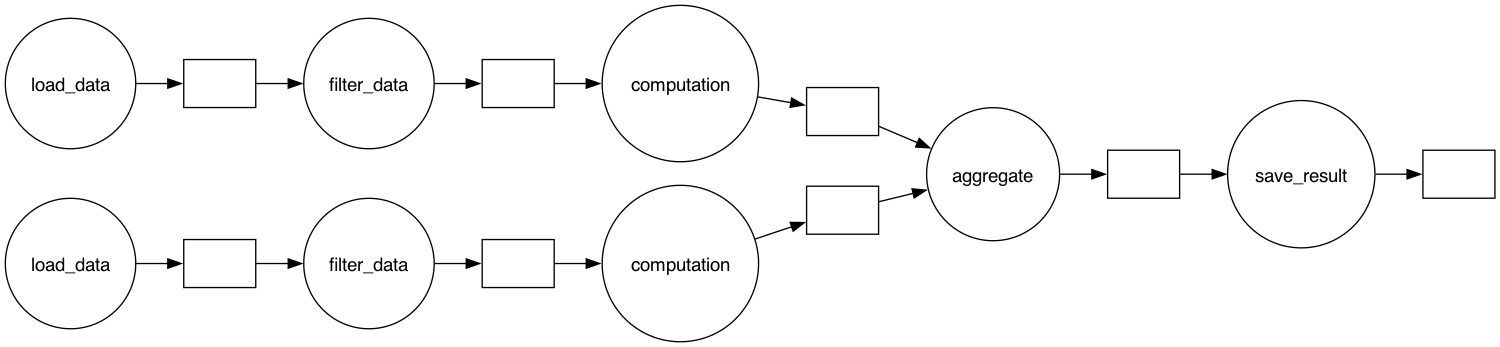

In [ ]:
# %pip install graphviz
# brew install graphviz
save_task.visualize(rankdir="LR")

По умолчанию Dask Delayed использует многопоточный планировщик (threaded scheduler) для минимизации затрат на передачу данных. Однако, если ваш код сильно зависит от GIL, например, при выполнении вычислений, доминирующих в чистом Python, или при использовании внешнего кода, который удерживает GIL, рекомендуется использовать другие планировщики.

## Dask Futures

## Dask ML

## Dask Scheduler

## Dask Graphs

## Dask ETL